# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 5: EDMD on Crowd Dynamics

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [358]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from EDMD import EDMD
from tqdm import tqdm
from io import StringIO
from datafold.appfold import EDMD as datafold_EDMD
from datafold.dynfold.transform import TSCPolynomialFeatures
from datafold.pcfold import TSCDataFrame

from Observables import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Trajectory Dataset

In [359]:
with open('data/postvis.traj') as f:
    lines = f.read()
ped_traj_df = pd.read_csv(StringIO(lines), sep=' ')
ped_traj_df

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.400000,0.957365,5.890973,4.204623,6.312940,4.166664,4
1,2,0.400000,1.033053,8.607234,7.263299,9.384863,7.601927,4
2,3,0.400000,1.117193,1.973335,2.212365,2.630341,2.376340,4
3,4,0.400000,1.178352,7.635275,3.410553,7.958087,3.439929,4
4,5,0.400000,1.033995,6.186206,3.221315,6.669568,2.889827,4
...,...,...,...,...,...,...,...,...
5144,74,54.851343,55.587172,26.442616,5.142354,27.111536,5.142354,4
5145,43,55.033973,55.814458,24.584583,5.258363,25.211121,5.258363,4
5146,43,55.814458,56.594944,25.211121,5.258363,25.837659,5.258363,4
5147,43,56.594944,57.375429,25.837659,5.258363,26.464197,5.258363,4


In [360]:
print(f"Delta t for pedestrian 1 is {np.diff(ped_traj_df[ped_traj_df.pedestrianId == 1].simTime.to_numpy())[0]:0.4f}")
print(f"Delta t for pedestrian 2 is {np.diff(ped_traj_df[ped_traj_df.pedestrianId == 2].simTime.to_numpy())[1]:0.4f}")

Delta t for pedestrian 1 is 0.5574
Delta t for pedestrian 2 is 0.6331


## Resampling Pedestrian Steps

In [610]:
delta_t = 0.4

resampled_trajectories = resample_trajectory(ped_traj_df, delta_t)
ped_traj_df_formatted_reduced = resampled_trajectories
ped_traj_df_formatted_reduced

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


,ID,time,x1,x2,y1,y2
0,1,0.4,5.890973,4.204623,6.312940,4.166664
1,1,0.8,6.193803,4.177381,6.420263,4.238213
2,1,1.2,6.420263,4.238213,6.677211,4.309651
3,1,1.6,6.677211,4.309651,7.095194,4.382074
4,1,2.0,6.677211,4.309651,7.095194,4.382074
...,...,...,...,...,...,...
7667,100,47.6,24.860900,4.471115,25.525460,4.471115
7668,100,48.0,25.525460,4.471115,26.190021,4.471115
7669,100,48.4,25.525460,4.471115,26.190021,4.471115
7670,100,48.8,26.190021,4.471115,26.821573,4.413564


# Actual Pedestrian Trajectories

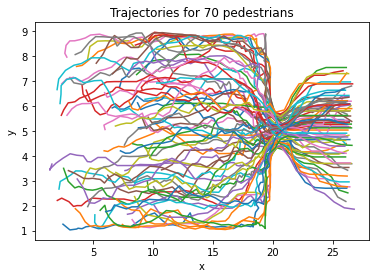

In [134]:
fig, ax = plt.subplots()
plot_trajectories(ped_traj_df_formatted, 70, ax)

# Finding Center of Gravity from Actual Data

In [611]:
center_of_gravity = find_center_of_gravity(ped_traj_df_formatted_reduced)

100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [00:06<00:00, 22.18it/s]


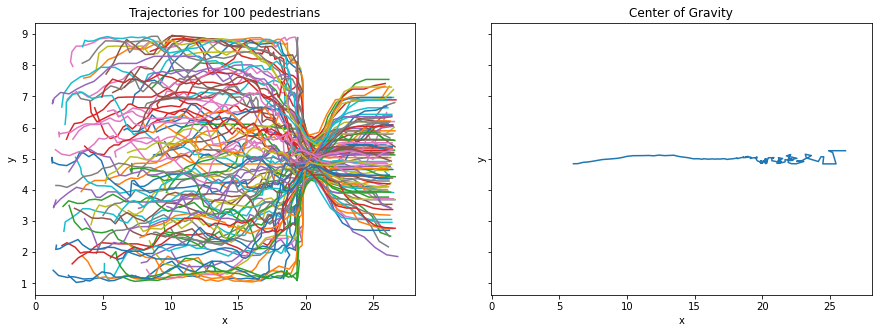

In [613]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
plot_trajectories(ped_traj_df_formatted_reduced, 100, axs[0])
axs[1].plot(center_of_gravity[:,0], center_of_gravity[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Center of Gravity")
fig.savefig('figures/ped_traj_and_cog_actual.png')

## Predicting the center of gravity

In [619]:
t_eval = np.arange(0.4, len(center_of_gravity)*0.4, 0.4)
cog_arr = np.concatenate([np.ones_like(t_eval.reshape(t_eval.shape[0],-1)), t_eval.reshape(t_eval.shape[0],-1), center_of_gravity[:-1], center_of_gravity[1:]], axis=1)
cog_df = pd.DataFrame(cog_arr, columns=['ID', 'time', 'x1', 'x2', 'y1', 'y2'])
cog_df

,ID,time,x1,x2,y1,y2
0,1.0,0.4,6.033272,4.840303,6.341797,4.842538
1,1.0,0.8,6.341797,4.842538,6.785710,4.887165
2,1.0,1.2,6.785710,4.887165,7.068227,4.894782
3,1.0,1.6,7.068227,4.894782,7.391270,4.915251
4,1.0,2.0,7.391270,4.915251,7.761620,4.944805
...,...,...,...,...,...,...
137,1.0,55.2,24.905685,5.258363,24.905685,5.258363
138,1.0,55.6,24.905685,5.258363,25.532223,5.258363
139,1.0,56.0,25.532223,5.258363,25.532223,5.258363
140,1.0,56.4,25.532223,5.258363,26.158761,5.258363


In [620]:
polynomial_observables = Polynomials(2)
edmd = EDMD(cog_df, 2, polynomial_observables)
edmd.fit()

In [621]:
initial_values = cog_df.groupby('ID').first().iloc[:,1:-2]
initial_values.insert(0,'ID',initial_values.index)
initial_values.insert(1,'time', 0)
cog_pred = edmd.predict(initial_values, t_range=t_eval)
cog_pred

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


,ID,time,x1,x2
1.0,1.0,0.0,6.033272,4.840303
0.0,1.0,0.8,6.368197,4.864024
0.0,1.0,1.2,6.720561,4.888917
0.0,1.0,1.6,7.090594,4.914838
0.0,1.0,2.0,7.478222,4.941583
...,...,...,...,...
0.0,1.0,55.2,24.905971,5.108989
0.0,1.0,55.6,25.008381,5.112487
0.0,1.0,56.0,25.111072,5.115985
0.0,1.0,56.4,25.214035,5.119484


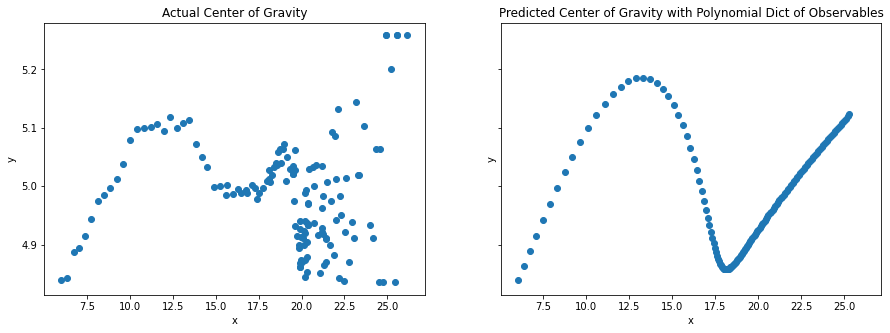

In [622]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(cog_df.iloc[:,2], cog_df.iloc[:,3])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(cog_pred.iloc[:,2], cog_pred.iloc[:,3])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")
fig.savefig('figures/predicted_traj_poly.png')

## MSE Loss

In [623]:
print(f"MSE combined is {mse_all_traj(cog_df, cog_pred)}")

MSE combined is 0.3892078910417871


## COG with DMD

In [624]:
identity_observables = Identity()
dmd = EDMD(cog_df, 2, identity_observables)
dmd.fit()
initial_values = cog_df.groupby('ID').first().iloc[:,1:-2]
initial_values.insert(0,'ID',initial_values.index)
initial_values.insert(1,'time', 0)
cog_pred_dmd = dmd.predict(initial_values, t_range=t_eval)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


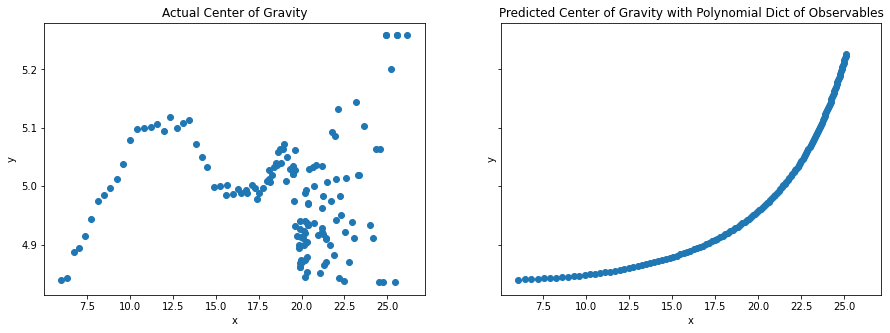

In [625]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(cog_df.iloc[:,2], cog_df.iloc[:,3])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(cog_pred_dmd.iloc[:,2], cog_pred_dmd.iloc[:,3])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")
fig.savefig('figures/predicted_traj_identity.png')

In [626]:
print(f"MSE combined is {mse_all_traj(cog_df, cog_pred_dmd)}")

MSE combined is 1.7469548195209197


# Applying EDMD with Polynomial Dictionary of Observables

In [583]:
polynomial_observables = Polynomials(2)
polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,:-2])
polynomial_observables.segregate_observables_from_variable(polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,:-2]))

,ID,time,x1^0x2^1,x1^0x2^2,x1^1x2^0,x1^1x2^1,x1^2x2^0
0,1,0.4,4.204623,17.678859,5.890973,24.769322,34.703560
1,1,0.8,4.177381,17.450516,6.193803,25.873877,38.363193
2,1,1.2,4.238213,17.962450,6.420263,27.210444,41.219781
3,1,1.6,4.309651,18.573088,6.677211,28.776444,44.585142
4,1,2.0,4.309651,18.573088,6.677211,28.776444,44.585142
...,...,...,...,...,...,...,...
7667,100,47.6,4.471115,19.990873,24.860900,111.155952,618.064345
7668,100,48.0,4.471115,19.990873,25.525460,114.127279,651.549127
7669,100,48.4,4.471115,19.990873,25.525460,114.127279,651.549127
7670,100,48.8,4.471115,19.990873,26.190021,117.098605,685.917190


In [602]:
polynomial_observables = Polynomials(2)
edmd = EDMD(ped_traj_df_formatted_reduced, 2, polynomial_observables)
edmd.fit()
t_eval = np.arange(0.4, 30, delta_t)

In [603]:
initial_values = ped_traj_df_formatted_reduced.groupby('ID').first().iloc[:,1:-2]
initial_values.insert(0,'ID',initial_values.index)
initial_values.insert(1,'time', 0)
traj_pred = edmd.predict(initial_values, t_range=t_eval)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


In [604]:
traj_pred_formatted = remove_extrapolated_data(traj_pred, ped_traj_df_formatted_reduced)
traj_pred_formatted#.groupby("ID").count()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 218.49it/s]


,ID,time,x1,x2
1,1.0,0.0,5.890973,4.204623
0,1.0,0.8,6.366620,4.237626
0,1.0,1.2,6.832840,4.269056
0,1.0,1.6,7.290289,4.298965
0,1.0,2.0,7.739594,4.327400
...,...,...,...,...
0,100.0,28.0,27.024248,3.947685
0,100.0,28.4,27.698028,3.980028
0,100.0,28.8,28.402171,4.013665
0,100.0,29.2,29.139382,4.048737


In [607]:
ped_traj_df_formatted_reduced.groupby('ID').count()

,time,x1,x2,y1,y2
ID,,,,,
1,65,65,65,65,65
2,56,56,56,56,56
3,112,112,112,112,112
4,104,104,104,104,104
5,67,67,67,67,67
...,...,...,...,...,...
96,101,101,101,101,101
97,84,84,84,84,84
98,41,41,41,41,41


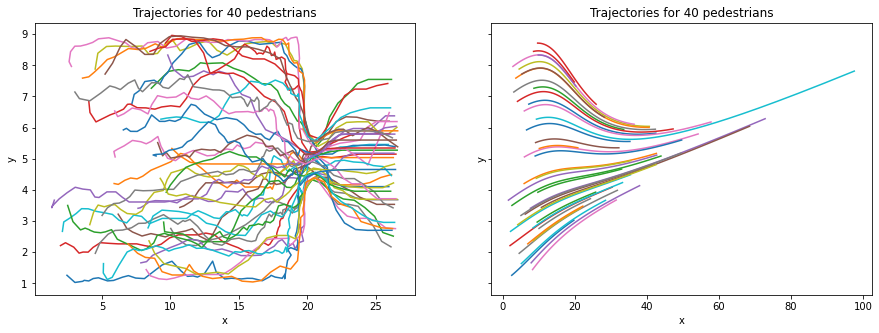

In [627]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=True)
no_peds = 40
plot_trajectories(ped_traj_df_formatted_reduced, no_peds, axs[0])
plot_trajectories(traj_pred_formatted, no_peds, axs[1])
fig.savefig('figures/edmd_traj_pred.png')

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:03<00:00, 22.85it/s]


(Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Predicted Center of Gravity with Polynomial Dict of Observables'))

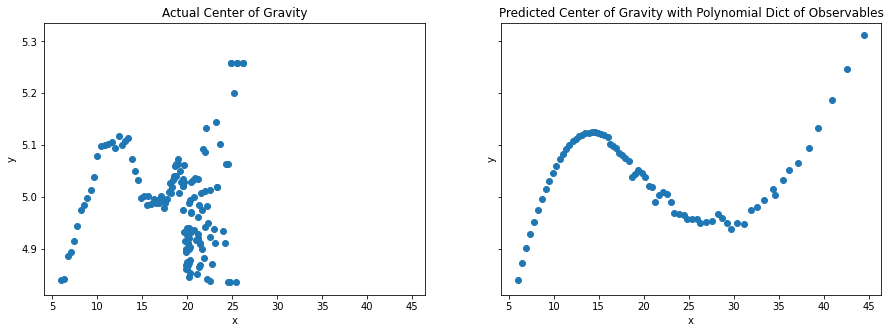

In [609]:
# center_of_gravity = find_center_of_gravity(ped_traj_df_formatted)
center_of_gravity_edmd = find_center_of_gravity(traj_pred_formatted)
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(center_of_gravity_edmd[:,0], center_of_gravity_edmd[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")

In [189]:
print(f"MSE of center of gravity is {np.sum((center_of_gravity - center_of_gravity_edmd[:center_of_gravity.shape[0],:])**2) / center_of_gravity_edmd.shape[0]:0.5f}")

MSE of center of gravity is 28.88005


# Applying EDMD with Identity Dictionary of Observables

In [190]:
identity_observables = Identity()
identity_observables.fit(ped_traj_df_formatted_reduced.iloc[:,0:4])
edmd_identity = EDMD(ped_traj_df_formatted_reduced, 2, identity_observables)
edmd_identity.fit()
traj_pred_identity = edmd_identity.predict(initial_values, t_range=t_eval)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


In [192]:
traj_pred_identity = remove_extrapolated_data(traj_pred_identity, ped_traj_df_formatted_reduced)
traj_pred_identity

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 647.04it/s]


,ID,time,x1,x2
1,1.0,0.0,5.890973,4.204623
1,1.0,0.0,5.890973,4.204623
0,1.0,0.8,6.121398,4.195532
0,1.0,1.2,6.354225,4.186725
0,1.0,1.6,6.589493,4.178205
...,...,...,...,...
0,100.0,25.6,10.815780,2.113177
0,100.0,26.0,11.025266,2.117170
0,100.0,26.4,11.237403,2.121375
0,100.0,26.8,11.452230,2.125797


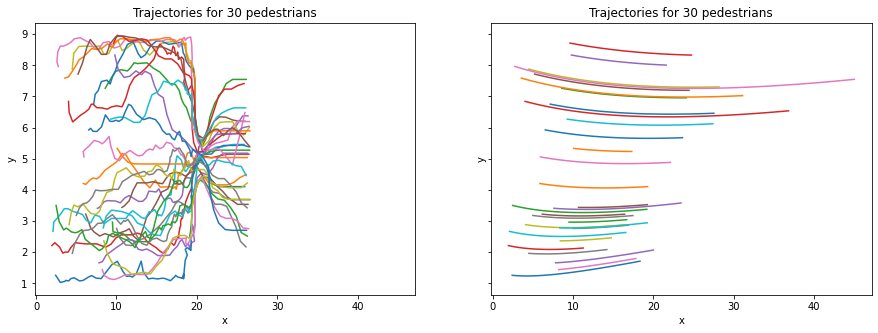

In [193]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
no_peds = 30
plot_trajectories(ped_traj_df_formatted_reduced, no_peds, axs[0])
plot_trajectories(traj_pred_identity, no_peds, axs[1])

# Datafold

In [552]:
tsc_traj = TSCDataFrame(resampled_trajectories.set_index(['ID', 'time']))
tsc_traj = tsc_traj[['x1', 'x2']]
tsc_traj

feature          x1        x2
ID  time                     
1   0.4    5.890973  4.204623
    0.8    6.193803  4.177381
    1.2    6.420263  4.238213
    1.6    6.677211  4.309651
    2.0    6.677211  4.309651
...             ...       ...
100 47.6  24.860900  4.471115
    48.0  25.525460  4.471115
    48.4  25.525460  4.471115
    48.8  26.190021  4.471115
    49.2  26.190021  4.471115

[7672 rows x 2 columns]

In [646]:
from datafold.dynfold.transform import TSCPolynomialFeatures, TSCRadialBasis
from datafold.pcfold import GaussianKernel

dict_step = [
    (
        "polynomial",
        TSCPolynomialFeatures(degree=2),
    )
]

# dict_step = [
#     (
#         "rbf",
#         TSCRadialBasis(
#             kernel=GaussianKernel(epsilon=0.008), center_type="initial_condition"
#         ),
#     )
# ]

edmd_poly = datafold_EDMD(dict_steps=dict_step, include_id_state=True).fit(X=tsc_traj)
edmd_poly_values = edmd_poly.predict(tsc_traj.initial_states())

In [647]:
edmd_poly.transform(tsc_traj)

feature          x1        x2        x1^2       x1 x2       x2^2
ID  time                                                        
1   0.4    5.890973  4.204623   34.703560   24.769322  17.678859
    0.8    6.193803  4.177381   38.363193   25.873877  17.450516
    1.2    6.420263  4.238213   41.219781   27.210444  17.962450
    1.6    6.677211  4.309651   44.585142   28.776444  18.573088
    2.0    6.677211  4.309651   44.585142   28.776444  18.573088
...             ...       ...         ...         ...        ...
100 47.6  24.860900  4.471115  618.064345  111.155952  19.990873
    48.0  25.525460  4.471115  651.549127  114.127279  19.990873
    48.4  25.525460  4.471115  651.549127  114.127279  19.990873
    48.8  26.190021  4.471115  685.917190  117.098605  19.990873
    49.2  26.190021  4.471115  685.917190  117.098605  19.990873

[7672 rows x 5 columns]

AttributeError: 'AxesSubplot' object has no attribute 'set_titel'

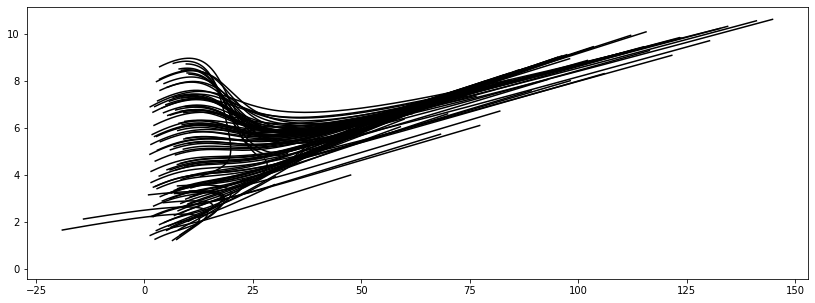

In [649]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

for _id, df in edmd_poly_values.itertimeseries():
    ax.plot(df["x1"].to_numpy(), df["x2"].to_numpy(), 0.1, c="black")
ax.set_titel('Datafold prediction of trajectories')
ax.set_xlabel('x'); ax.set_ylabel('y')

# fig.savefig('figures/edmd_traj_pred_datafold.png')